In [3]:
# Azure Machine Learning Configuration

In [1]:
import azureml.core
from azureml.core import Workspace
from dotenv import set_key, get_key, find_dotenv
from pathlib import Path
from utilities import get_auth

In [2]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.17.0 of the Azure ML SDK


In [3]:
subscription_id = "1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98"
resource_group = "ProjektAzure"
workspace_name = "ProjektAzure"
workspace_region = "East US"

In [4]:
env_path = find_dotenv()
if env_path == "":
    Path(".env").touch()
    env_path = find_dotenv()

In [5]:
set_key(env_path, "subscription_id", subscription_id) 
set_key(env_path, "resource_group", resource_group)
set_key(env_path, "workspace_name", workspace_name)
set_key(env_path, "workspace_region", workspace_region)

(True, 'workspace_region', 'East US')

In [6]:
# Create the workspace using the specified parameters
ws = Workspace.create(
    name=workspace_name,
    subscription_id=subscription_id,
    resource_group=resource_group,
    location=workspace_region,
    create_resource_group=True,
    auth=get_auth(env_path),
    exist_ok=True,
)

# write the details of the workspace to a configuration file
ws.write_config()

In [7]:
# load workspace configuration
ws = Workspace.from_config(auth=get_auth(env_path))
ws.get_details()

{'id': '/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourceGroups/ProjektAzure/providers/Microsoft.MachineLearningServices/workspaces/ProjektAzure',
 'name': 'ProjektAzure',
 'location': 'eastus',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'sku': 'Basic',
 'workspaceid': 'ec3d9bcd-0a08-464f-ae43-b69afde74018',
 'sdkTelemetryAppInsightsKey': 'f5784ccd-178d-4ecc-9998-b05841b44ae9',
 'description': '',
 'friendlyName': 'ProjektAzure',
 'creationTime': '2020-12-21T20:48:27.3350460+00:00',
 'keyVault': '/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourcegroups/projektazure/providers/microsoft.keyvault/vaults/projektakeyvaultceb809a5',
 'applicationInsights': '/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourcegroups/projektazure/providers/microsoft.insights/components/projektainsights99765023',
 'identityPrincipalId': '6bcd4c16-2e88-4cd9-afbd-81b67e195a4c',
 'identityTenantId': '3b50229c-cd78-4588-9bcf-97b7629e2f0f',
 'identityType': 'SystemAssigned

In [8]:
%%writefile scripts/XMLDataset.py
import os
import xml.etree.ElementTree as ET
import torch
import transforms as T
from PIL import Image


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, train=True):
        self.root = root
        self.transforms = transforms
        self.labels_dict = {'cat': 1, 'dog': 2, 'monkey': 3}
#         self.labels_dict['cat'] = 1
#         self.labels_dict['dog'] = 2
#         self.labels_dict['monkey'] = 3
        # load all image files
        if train:
            self.imgs_path = os.path.join(root, "Data/JPEGImages")
            self.imgs = list(sorted(os.listdir(self.imgs_path)))
            self.xmls_path = os.path.join(root, "Data/Annotations")
        else:
            self.imgs_path = os.path.join(root, "Data/JPEGImagesTest")
            self.imgs = list(sorted(os.listdir(self.imgs_path)))
            self.xmls_path = os.path.join(root, "Data/AnnotationsTest")

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_path, self.imgs[idx])
        xml_path = os.path.join(
            self.xmls_path, "{}.xml".format(self.imgs[idx].strip(".jpg"))
        )
        img = Image.open(img_path).convert("RGB")

        # parse XML annotation
        tree = ET.parse(xml_path)
        t_root = tree.getroot()

        # get bounding box coordinates
        boxes = []
        labels = []
        for obj in t_root.findall("object"):
            bnd_box = obj.find("bndbox")
            xmin = float(bnd_box.find("xmin").text)
            xmax = float(bnd_box.find("xmax").text)
            ymin = float(bnd_box.find("ymin").text)
            ymax = float(bnd_box.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            label_name = str(obj.find("name").text)
#             if self.labels_dict:
#                 if label_name not in self.labels_dict.keys():
#                     self.labels_dict[label_name] = max(self.labels_dict.values()) + 1
#             else:
#                 self.labels_dict[label_name] = 1
#             print(label_name + ": " + str(self.labels_dict[label_name]))
            labels.append(self.labels_dict[label_name])
        num_objs = len(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.as_tensor(labels)
#         print(labels)
#         labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])

        # area of the bounding box, used during evaluation with the COCO metric for small, medium and large boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Overwriting scripts/XMLDataset.py


In [41]:
%%writefile scripts/maskrcnn_model.py
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead


def get_model(
    num_classes,
    anchor_sizes,
    anchor_aspect_ratios,
    rpn_nms_threshold,
    box_nms_threshold,
    box_score_threshold,
    num_box_detections,
):

    # load pre-trained mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True,
        rpn_nms_thresh=rpn_nms_threshold,
        box_nms_thresh=box_nms_threshold,
        box_score_thresh=box_score_threshold,
        box_detections_per_img=num_box_detections,
    )
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    anchor_sizes = tuple([float(i) for i in anchor_sizes.split(",")])
    anchor_aspect_ratios = tuple([float(i) for i in anchor_aspect_ratios.split(",")])

    # create an anchor_generator for the FPN which by default has 5 outputs
    anchor_generator = AnchorGenerator(
        sizes=tuple([anchor_sizes for _ in range(5)]),
        aspect_ratios=tuple([anchor_aspect_ratios for _ in range(5)]),
    )
    model.rpn.anchor_generator = anchor_generator

    # get number of input features for the RPN returned by FPN (256)
    in_channels = model.backbone.out_channels

    # replace the RPN head
    model.rpn.head = RPNHead(
        in_channels, anchor_generator.num_anchors_per_location()[0]
    )

    # turn off masks since dataset only has bounding boxes
    model.roi_heads.mask_roi_pool = None

    return model

Overwriting scripts/maskrcnn_model.py


In [42]:
%%writefile scripts/train.py
import os
import sys

sys.path.append("./cocoapi/PythonAPI/")

import torch
import argparse
import utils
from XMLDataset import BuildDataset, get_transform
from maskrcnn_model import get_model
from engine import train_one_epoch, evaluate

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="PyTorch Object Detection Training")
    parser.add_argument(
        "--data_path", default="./Data/", help="the path to the dataset"
    )
    parser.add_argument("--batch_size", default=2, type=int)
    parser.add_argument(
        "--epochs", default=10, type=int, help="number of total epochs to run"
    )
    parser.add_argument(
        "--workers", default=4, type=int, help="number of data loading workers"
    )
    parser.add_argument(
        "--learning_rate", default=0.005, type=float, help="initial learning rate"
    )
    parser.add_argument("--momentum", default=0.9, type=float, help="momentum")
    parser.add_argument(
        "--weight_decay",
        default=0.0005,
        type=float,
        help="weight decay (default: 1e-4)",
    )
    parser.add_argument(
        "--lr_step_size", default=3, type=int, help="decrease lr every step-size epochs"
    )
    parser.add_argument(
        "--lr_gamma",
        default=0.1,
        type=float,
        help="decrease lr by a factor of lr-gamma",
    )
    parser.add_argument("--print_freq", default=10, type=int, help="print frequency")
    parser.add_argument("--output_dir", default="outputs", help="path where to save")
    parser.add_argument("--anchor_sizes", default="16", type=str, help="anchor sizes")
    parser.add_argument(
        "--anchor_aspect_ratios", default="1.0", type=str, help="anchor aspect ratios"
    )
    parser.add_argument(
        "--rpn_nms_thresh",
        default=0.7,
        type=float,
        help="NMS threshold used for postprocessing the RPN proposals",
    )
    parser.add_argument(
        "--box_nms_thresh",
        default=0.5,
        type=float,
        help="NMS threshold for the prediction head. Used during inference",
    )
    parser.add_argument(
        "--box_score_thresh",
        default=0.05,
        type=float,
        help="during inference only return proposals"
        "with a classification score greater than box_score_thresh",
    )
    parser.add_argument(
        "--box_detections_per_img",
        default=100,
        type=int,
        help="maximum number of detections per image, for all classes",
    )
    args = parser.parse_args()
    
data_path = args.data_path

# use our dataset and defined transformations
dataset = BuildDataset(data_path, get_transform(train=True), train=True)
dataset_test = BuildDataset(data_path, get_transform(train=False), train=False)
# dataset_test = BuildDataset(data_path, get_transform(train=False), train=True)

# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, range(0, len(dataset)))
# dataset_test = torch.utils.data.Subset(dataset_test, range(0, len(dataset_test)))
# dataset = torch.utils.data.Subset(dataset, indices[:-100])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

batch_size = args.batch_size
workers = args.workers

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=workers,
    collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    num_workers=workers,
    collate_fn=utils.collate_fn,
)


# our dataset has two classes only - background and out of stock
num_classes = 4

model = get_model(
    num_classes,
    args.anchor_sizes,
    args.anchor_aspect_ratios,
    args.rpn_nms_thresh,
    args.box_nms_thresh,
    args.box_score_thresh,
    args.box_detections_per_img,
)




# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# move model to the right device
model.to(device)

learning_rate = args.learning_rate
momentum = args.momentum
weight_decay = args.weight_decay

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay
)

lr_step_size = args.lr_step_size
lr_gamma = args.lr_gamma

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=lr_step_size, gamma=lr_gamma
)

# number of training epochs
num_epochs = args.epochs
print_freq = args.print_freq

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=print_freq)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset after every epoch
    evaluate(model, data_loader_test, device=device)

# save model
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
torch.save(model.state_dict(), os.path.join(args.output_dir, "model_latest.pth"))

print("That's it!")

Overwriting scripts/train.py


TRENOWANIE

In [9]:
import sys

sys.path.append("scripts")
sys.path.append("scripts/cocoapi/PythonAPI/")

import azureml.core
from azureml.core import Workspace, Experiment
from azureml.widgets import RunDetails
from azureml.train.dnn import PyTorch

from dotenv import set_key, get_key, find_dotenv
from utilities import get_auth, download_data

import torch
from scripts.XMLDataset import BuildDataset, get_transform
from scripts.maskrcnn_model import get_model

from PIL import Image, ImageDraw
from IPython.display import display

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.17.0


In [10]:
env_path = find_dotenv(raise_error_if_not_found=True)

In [11]:
# data_file = "Data.zip"
# data_url = ("https://bostondata.blob.core.windows.net/builddata/{}".format(data_file))
# download_data(data_file, data_url)

In [12]:
ws = Workspace.from_config(auth=get_auth(env_path))
print(ws.name, ws.resource_group, ws.location, sep="\n")

ProjektAzure
ProjektAzure
eastus


In [13]:
exp = Experiment(workspace=ws, name='torchvision')

In [14]:
# with open("scripts/train.py", "r") as f:
#     print(f.read())

In [15]:
num_epochs = 5
script_params = {
    "--data_path": ".",
    "--workers": 8,
    "--learning_rate": 0.005,
    "--epochs": num_epochs,
    "--anchor_sizes": "16,32,64,128,256,512",
    "--anchor_aspect_ratios": "0.25,0.5,1.0,2.0",
    "--rpn_nms_thresh": 0.5,
    "--box_nms_thresh": 0.3,
    "--box_score_thresh": 0.10,
}

estimator = PyTorch(
    source_directory="./scripts",
    script_params=script_params,
    compute_target="local",
    entry_script="train.py",
    use_docker=False,
    user_managed=True,
    use_gpu=True,
)

WARNING - 'use_docker' parameter will be deprecated. Please use 'environment_definition' instead.


In [16]:
estimator.run_config.environment.python.interpreter_path = ("/anaconda/envs/azureml_py36_pytorch/bin/python")
estimator.run_config.history.snapshot_project = False

In [51]:
run = exp.submit(estimator)
RunDetails(run).show()

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [52]:
run.wait_for_completion(show_output=True)

RunId: torchvision_1609353658_17133c27
Web View: https://ml.azure.com/experiments/torchvision/runs/torchvision_1609353658_17133c27?wsid=/subscriptions/1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98/resourcegroups/ProjektAzure/workspaces/ProjektAzure

Streaming azureml-logs/70_driver_log.txt

[2020-12-30T18:41:00.841608] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['train.py', '--data_path', '.', '--workers', '8', '--learning_rate', '0.005', '--epochs', '5', '--anchor_sizes', '16,32,64,128,256,512', '--anchor_aspect_ratios', '0.25,0.5,1.0,2.0', '--rpn_nms_thresh', '0.5', '--box_nms_thresh', '0.3', '--box_score_thresh', '0.1'])
Script type = None
Starting the daemon thread to refresh tokens in background for process with pid = 6571
Entering Run History Context Manager.
[2020-12-30

Test:  [25/26]  eta: 0:00:00  model_time: 0.7137 (0.7284)  evaluator_time: 0.0022 (0.0028)  time: 0.7182  data: 0.0047  max mem: 4699
Test: Total time: 0:00:19 (0.7474 s / it)
Averaged stats: model_time: 0.7137 (0.7284)  evaluator_time: 0.0022 (0.0028)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.

Epoch: [2]  [ 20/235]  eta: 0:06:36  lr: 0.005000  loss: 0.4654 (0.4735)  loss_classifier: 0.0573 (0.0638)  loss_box_reg: 0.0703 (0.0776)  loss_objectness: 0.1059 (0.1188)  loss_rpn_box_reg: 0.2007 (0.2133)  time: 1.8382  data: 0.0092  max mem: 5237
Epoch: [2]  [ 30/235]  eta: 0:06:17  lr: 0.005000  loss: 0.4638 (0.4760)  loss_classifier: 0.0648 (0.0671)  loss_box_reg: 0.0768 (0.0818)  loss_objectness: 0.0965 (0.1116)  loss_rpn_box_reg: 0.2172 (0.2155)  time: 1.8453  data: 0.0051  max mem: 5237
Epoch: [2]  [ 40/235]  eta: 0:05:56  lr: 0.005000  loss: 0.5054 (0.4819)  loss_classifier: 0.0799 (0.0695)  loss_box_reg: 0.0699 (0.0846)  loss_objectness: 0.0911 (0.1127)  loss_rpn_box_reg: 0.2125 (0.2150)  time: 1.8167  data: 0.0059  max mem: 5237
Epoch: [2]  [ 50/235]  eta: 0:05:37  lr: 0.005000  loss: 0.4861 (0.4831)  loss_classifier: 0.0799 (0.0711)  loss_box_reg: 0.0811 (0.0887)  loss_objectness: 0.0946 (0.1125)  loss_rpn_box_reg: 0.1871 (0.2108)  time: 1.7949  data: 0.0060  max mem: 5237


Epoch: [3]  [ 70/235]  eta: 0:04:48  lr: 0.000500  loss: 0.3543 (0.3925)  loss_classifier: 0.0411 (0.0550)  loss_box_reg: 0.0585 (0.0735)  loss_objectness: 0.0714 (0.0881)  loss_rpn_box_reg: 0.1704 (0.1759)  time: 1.7269  data: 0.0061  max mem: 5237
Epoch: [3]  [ 80/235]  eta: 0:04:31  lr: 0.000500  loss: 0.4251 (0.3964)  loss_classifier: 0.0448 (0.0550)  loss_box_reg: 0.0602 (0.0734)  loss_objectness: 0.0987 (0.0906)  loss_rpn_box_reg: 0.1859 (0.1773)  time: 1.7628  data: 0.0064  max mem: 5237
Epoch: [3]  [ 90/235]  eta: 0:04:19  lr: 0.000500  loss: 0.3689 (0.3930)  loss_classifier: 0.0440 (0.0540)  loss_box_reg: 0.0672 (0.0718)  loss_objectness: 0.0712 (0.0881)  loss_rpn_box_reg: 0.1826 (0.1790)  time: 1.9474  data: 0.0064  max mem: 5237
Epoch: [3]  [100/235]  eta: 0:04:02  lr: 0.000500  loss: 0.3566 (0.3892)  loss_classifier: 0.0418 (0.0536)  loss_box_reg: 0.0672 (0.0718)  loss_objectness: 0.0648 (0.0872)  loss_rpn_box_reg: 0.1771 (0.1767)  time: 1.9881  data: 0.0062  max mem: 5237


Epoch: [4]  [120/235]  eta: 0:03:32  lr: 0.000500  loss: 0.3514 (0.3353)  loss_classifier: 0.0355 (0.0459)  loss_box_reg: 0.0634 (0.0642)  loss_objectness: 0.0635 (0.0621)  loss_rpn_box_reg: 0.1717 (0.1630)  time: 1.8243  data: 0.0060  max mem: 5275
Epoch: [4]  [130/235]  eta: 0:03:13  lr: 0.000500  loss: 0.4073 (0.3386)  loss_classifier: 0.0563 (0.0468)  loss_box_reg: 0.0666 (0.0650)  loss_objectness: 0.0689 (0.0634)  loss_rpn_box_reg: 0.1708 (0.1634)  time: 1.7264  data: 0.0059  max mem: 5275
Epoch: [4]  [140/235]  eta: 0:02:56  lr: 0.000500  loss: 0.2963 (0.3389)  loss_classifier: 0.0456 (0.0476)  loss_box_reg: 0.0459 (0.0656)  loss_objectness: 0.0648 (0.0640)  loss_rpn_box_reg: 0.1126 (0.1616)  time: 1.8862  data: 0.0058  max mem: 5275
Epoch: [4]  [150/235]  eta: 0:02:38  lr: 0.000500  loss: 0.3540 (0.3427)  loss_classifier: 0.0459 (0.0479)  loss_box_reg: 0.0566 (0.0660)  loss_objectness: 0.0527 (0.0643)  loss_rpn_box_reg: 0.1346 (0.1645)  time: 1.9744  data: 0.0061  max mem: 5275


{'runId': 'torchvision_1609353658_17133c27',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-12-30T18:41:00.640209Z',
 'endTimeUtc': '2020-12-30T19:18:40.848811Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': None,
  'azureml.git.repository_uri': 'https://github.com/ispmor/azure-project.git',
  'mlflow.source.git.repoURL': 'https://github.com/ispmor/azure-project.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '4ab77770258311ab80995d7793dabb2994cecf2c',
  'mlflow.source.git.commit': '4ab77770258311ab80995d7793dabb2994cecf2c',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': ['--data_path',
   '.',
   '--workers',
   '8',
   '--learning_rate',
   '0.005',
   '--epochs',
   '5',
   '--anchor_sizes',
   '16,32,64,128,256,512',
   '--anchor_aspect_ratios',
   '0.25,0.5,1.0,2.0'

In [53]:
run.get_file_names()

['azureml-logs/60_control_log.txt',
 'azureml-logs/70_driver_log.txt',
 'logs/azureml/6571_azureml.log',
 'logs/azureml/dataprep/python_span_123bc38b-ee0a-4e05-a72e-4b55058c2cb9.jsonl',
 'outputs/model_latest.pth']

In [54]:
run.get_metrics()

{'mAP@IoU=0.50': [0.5368647818430964,
  0.721874568282234,
  0.7416565309258751,
  0.7604463046961736,
  0.7774105899685001]}

In [55]:
run.register_model(model_name="torchvision_local_model", model_path="/outputs/model_latest.pth")

Model(workspace=Workspace.create(name='ProjektAzure', subscription_id='1db0a5ce-7de1-4082-8e25-3c5a4e5a9a98', resource_group='ProjektAzure'), name=torchvision_local_model, id=torchvision_local_model:12, version=12, tags={}, properties={})

In [56]:
run.download_file("outputs/model_latest.pth")

In [17]:
num_classes = 4
anchor_sizes = "16,32,64,128,256,512"
anchor_aspect_ratios = "0.25,0.5,1.0,2.0"
rpn_nms_threshold = 0.5
box_nms_threshold = 0.3
box_score_threshold = 0.1
num_box_detections = 100

In [18]:
# Load Mask RCNN model
model = get_model(
    num_classes,
    anchor_sizes,
    anchor_aspect_ratios,
    rpn_nms_threshold,
    box_nms_threshold,
    box_score_threshold,
    num_box_detections,
)

In [19]:
model_path = "model_latest.pth"
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [20]:
# Use a random subset of the data to visualize predictions on the images.
data_path = "./scripts"
dataset = BuildDataset(data_path, get_transform(train=False), train=False)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[-50:])

In [21]:
# for i in range(5):
#     img, _ = dataset[i]
#     model.eval()
#     with torch.no_grad():
#         prediction = model([img.to(device)])
#     img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
#     preds = prediction[0]["boxes"].cpu().numpy()
#     print(prediction[0]["scores"])
#     draw = ImageDraw.Draw(img)
#     for i in range(len(preds)):
#         draw.rectangle(
#             ((preds[i][0], preds[i][1]), (preds[i][2], preds[i][3])), outline="red"
#         )
#     display(img)

In [96]:
img, _ = dataset[1]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
preds = prediction[0]["boxes"].cpu().numpy()
print(prediction[0])

cat: 1
cat: 1
tensor([1, 1])
{'boxes': tensor([[ 85.4590,   1.1939, 375.8018, 255.7330],
        [277.7653,  39.8818, 471.1955, 262.2318],
        [  6.5119, 113.4419, 190.2725, 259.7766],
        [256.9143,  37.5042, 378.4611, 163.7820],
        [127.6844, 143.2307, 323.8057, 266.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9443, 0.9433, 0.2924, 0.2509, 0.1002], device='cuda:0')}


In [23]:
labels_dict = {1: "cat", 2: "dog", 3: "monkey"}

tensor([0.9834, 0.8881, 0.1116], device='cuda:0')
tensor([1, 3, 1], device='cuda:0')


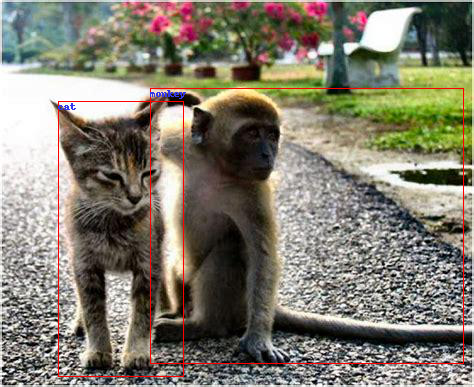

In [27]:
img, _ = dataset[12]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
preds = prediction[0]["boxes"].cpu().numpy()
print(prediction[0]["scores"])
print(prediction[0]['labels'])
draw = ImageDraw.Draw(img)
for i in range(len(preds)):
    if prediction[0]["scores"][i].item() > 0.5:
        draw.rectangle(
            ((preds[i][0], preds[i][1]), (preds[i][2], preds[i][3])), outline="red"
        )
        draw.text((preds[i][0], preds[i][1]), labels_dict[prediction[0]['labels'][i].item()], fill=(52, 55, 235,128))
display(img)

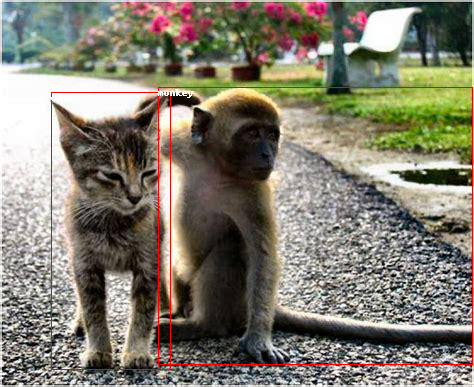

In [33]:
import xml.etree.ElementTree as ET
tree = ET.parse('scripts/Data/AnnotationsTest/cats_and_monkeys_029.xml')
# tree = ET.parse('scripts/Data/AnnotationsTest/cats_and_monkeys_029.xml')
t_root = tree.getroot()
img = Image.open('scripts/Data/JPEGImagesTest/cats_and_monkeys_029.jpg')
# img = Image.open('scripts/Data/JPEGImagesTest/cats_and_monkeys_029.jpg')
draw = ImageDraw.Draw(img)
for obj in t_root.findall("object"):
    bnd_box = obj.find("bndbox")
    xmin = float(bnd_box.find("xmin").text)
    xmax = float(bnd_box.find("xmax").text)
    ymin = float(bnd_box.find("ymin").text)
    ymax = float(bnd_box.find("ymax").text)
    label_name = str(obj.find("name").text)
    draw.rectangle(
            ((xmin, ymin), (xmax, ymax)), outline="red"
        )
    draw.text((xmin, ymin), label_name, fill=(255,255,255,128))
display(img)